<a href="https://colab.research.google.com/github/chimaobi-okite/PlantDiseaseClassification/blob/main/ArmyWorm2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Challenge Description

Fall armyworm is a devastating pest in Africa, where it has no natural predators - African farmers say the pest causes average maize losses of 31% annually. Maize is the most widely grown crop in Africa and a staple for around half the continent’s people - over 300 million Africans depend on the crop for food and nutritional security. For smallholder farmers in particular, maize is popular for its wide adaptability, valuable by-products and high yields.

Because of this reliance on staple crops for food security, Viral pests and diseases like fall armyworm are one of the leading causes of food insecurity and poverty in Africa. Thus there is an urgent need to design early intervention mechanisms to help prevent crop losses for smallholder farmers.

In this challenge, your objective is to classify if a plant has been affected by a fall armyworm. This is a binary image classification challenge. The solution will be deployed as part of a mobile-based edge application which can be used by smallholder farmers in Uganda and the rest of Africa to carry out field-based diagnosis and intervene before fall armyworm devastates their maize crop for the season.

## About Datasets

The dataset used in this note was collected from Zindi and canbe found [here](https://zindi.africa/competitions/makerere-fall-armyworm-crop-challenge/data)

The dataset contains images of maize crop leaves collected by research scientists from the Makerere Artificial Intelligence Lab, the Marconi Machine Learning Lab, and the National Crops Research Institute in Uganda. It contains 2699 images equally distributed across the healthy and fall armyworm classes.

The dataset does not contain any other attributes associated with the images. Images have not been subjected to any form of preprocessing.

## Loading The Data

install fastbook

In [1]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

import the neccessary libraries

In [2]:
import os
import pathlib, shutil
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fastbook import *
from fastai.vision.all import *  

extract image zip file to tmp folder

In [3]:
image_path = '/tmp/images'
if not os.path.exists(image_path):
  path = path = os.path.join('/tmp', 'images')
  os.mkdir(path)
  zip_ref = zipfile.ZipFile('/content/gdrive/MyDrive/ArmyWorm/Images.zip')
  zip_ref.extractall(path)
  zip_ref.close()

copy csv files to tmp folder

In [4]:
base_path = '/tmp'

csv_files = ['/content/gdrive/MyDrive/ArmyWorm/SampleSubmission.csv','/content/gdrive/MyDrive/ArmyWorm/Test.csv', 
             '/content/gdrive/MyDrive/ArmyWorm/Train.csv']

for file in csv_files:
    if os.path.isfile(file):
        shutil.copy(str(file), str(base_path))

In [5]:
## see sample of the train df
train = pd.read_csv('/tmp/Train.csv')
test = pd.read_csv('/tmp/Test.csv')
train.head()

,Image_id,Label
0,id_02amazy34fgh2.jpg,1
1,id_02mh3w48pmyc9.jpg,0
2,id_02rpb463h9d3w.jpg,0
3,id_02wc3jeeao8ol.jpg,1
4,id_03t2hapb8wz8p.jpg,1


## EDA

In [6]:
print(f'The train set contains {train.shape[0]} images')
print(f'The train set contains {test.shape[0]} images')

The train set contains 1619 images
The train set contains 1080 images


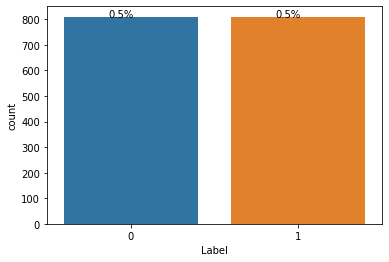

In [7]:
## see target distribution in train set
import seaborn as sns
ax = sns.countplot(x= 'Label', data = train)
for p in ax.patches:
  x,y = p.get_x(), p.get_y()
  height, width = p.get_height(), p.get_width()
  text = f'{round(height/train.shape[0],2)}%'
  ax.annotate(text, (x+width/3, height))
plt.show()

## Data Preparetion And Modelling

create a data loaders for the image files, labels are gotten from the csv file

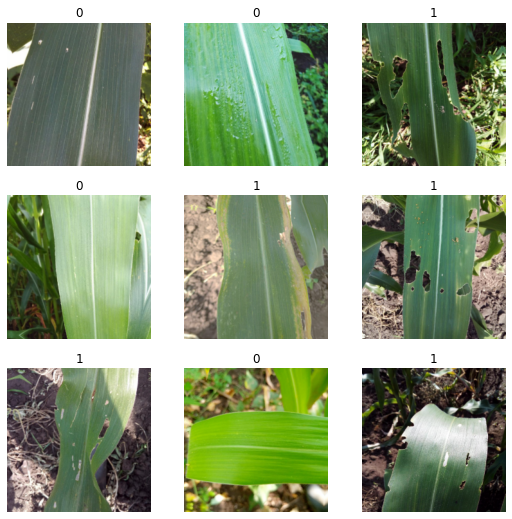

In [8]:
set_seed(42,True)  ## reproduce results
dls = ImageDataLoaders.from_df(train, fn_col='Image_id', label_col='Label', 
                               folder='/tmp/images', item_tfms=Resize(400),
                               seed = 42,
                               batch_tfms = aug_transforms(size=224, min_scale=0.75))
dls.show_batch() # Note the augmentation applied to the images!


### Build Base Model

From the eda part, we can see that the training set is small and the best approach to this task will be transfer learning. 
Lets start with resnet18

In [9]:
learn = vision_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.690226,0.160348,0.040248,00:50


epoch,train_loss,valid_loss,error_rate,time
0,0.155395,0.117968,0.030960,00:38
1,0.104894,0.081123,0.024768,00:39


See performance of our base model

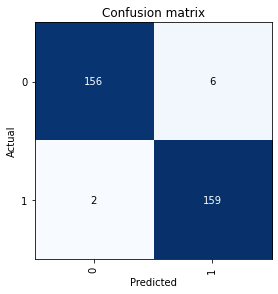

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

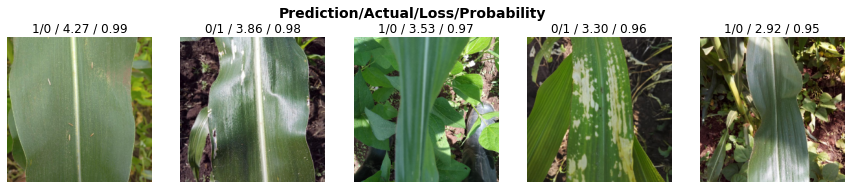

In [11]:
interp.plot_top_losses(5, nrows = 1)

### Improve Model

Our base model performance isnt that bad, but we can do better. Find a better learninng rate and train on more epochs

SuggestedLRs(valley=0.001737800776027143)

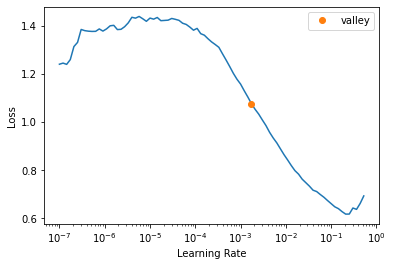

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.lr_find()

In [21]:
## fit using the best learning rate
set_seed(42, True)
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fit_one_cycle(3, 0.001737800776027143)

epoch,train_loss,valid_loss,error_rate,time
0,0.451162,0.142486,0.037152,01:01
1,0.250986,0.091177,0.024768,00:37
2,0.201645,0.075728,0.027864,00:38


In [22]:
learn.unfreeze()
learn.lr_find()

IndexError: ignored

In [ ]:
learn.fit_one_cycle(6, lr_max=0.00013182566908653826)

In [ ]:
##plot loss
learn.recorder.plot_loss()

Now we have over 99% accuracy and the loss is yet to converge. So we can train for more epochs to improve our model but for this case, this is good.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(3, nrows = 1)

## Making Prediction On Test set and Submission

In [ ]:
preds, _ = learn.get_preds(dl=dls.test_dl(test)) 
submission = pd.DataFrame({'Image_id': test['Image_id'], 'Label' : preds[:,1]})


In [ ]:
submission.to_csv('mysubmission.csv', index=False)

## Documentation

This solution had over 99% accuracy on validation set and an auc of 1 on the zindi leader board.